# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [40]:
import sys
from sqlalchemy import create_engine
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import nltk
nltk.download(['punkt','stopwords','wordnet','averaged_perceptron_tagger','omw'])

[nltk_data] Downloading package punkt to /Users/Yong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Yong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Yong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Yong/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw to /Users/Yong/nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

In [2]:
# load data from database
model_filepath = 'DisasterResponseModel.pkl'
database_filepath = '../data/DisasterResponse.db'

engine=create_engine('sqlite:///{}'.format(database_filepath))
print ('Tables in the database: {}'.format(engine.table_names()))


df = pd.read_sql_table('message_categories',con=engine)
X = df["message"]
y=df.drop(['id', 'message', 'original', 'genre'], axis=1)
categories = y.columns

Tables in the database: ['message_categories']


In [3]:
#checking values
y['related'].value_counts()

1    20093
0     6122
Name: related, dtype: int64

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 2. Write a tokenization function to process your text data

In [5]:
def plot_validation_curve(clf,X,Y,param,paramlist,K,x_label,ptitle):

    train_score, valid_score = validation_curve(clf, X, Y, param_name=param, param_range=paramlist, cv=K, scoring='f1_samples')

    train_score_mean = train_score.mean(1)
    train_score_std = train_score.std(1)
    valid_score_mean = valid_score.mean(1)
    valid_score_std = valid_score.std(1)

    plt.grid()
    plt.fill_between(paramlist, train_score_mean - train_score_std,
                     train_score_mean + train_score_std, color='r', alpha=0.1)
    plt.fill_between(paramlist, valid_score_mean - valid_score_std,
                     valid_score_mean + valid_score_std, color='g', alpha=0.1)

    plt.plot(paramlist, train_score_mean, 'o-', c='r', label='train score')
    plt.plot(paramlist, valid_score_mean, 'o-', c='g', label='validation score')
    plt.legend(loc='best')
    plt.title(ptitle)
    plt.xlabel(x_label)
    plt.ylabel('neg_mean_squared_error')
    plt.savefig(ptitle)
    plt.show()

    
def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens


def evaluate_model(model, X_test, Y_test, category_names):
    Y_pred=model.predict(X_test)

    result = precision_recall_fscore_support(Y_test,Y_pred)
    with open('test.log','a+') as f:
        for i,col in enumerate(category_names):
            accu = accuracy_score(Y_test.loc[:,col],Y_pred[:,i])
            score = ('{}\n Accuracy:  {:.4f}   % Precision: {:.4f}   % Recall {:.4f}   % support {:.4f} \n'.format(
                col,accu,result[0][i],result[1][i],result[2][i]))
            print(score)
            f.write(score)
        avg_score = ('label ranking average precision: {}'.format(label_ranking_average_precision_score(Y_test,Y_pred)))
        print(avg_score)
        f.write(avg_score)

        classrep=classification_report(Y_test.values, Y_pred, target_names=category_names)
        print(classrep)
        f.write(classrep)


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Applications/anaconda3/lib/

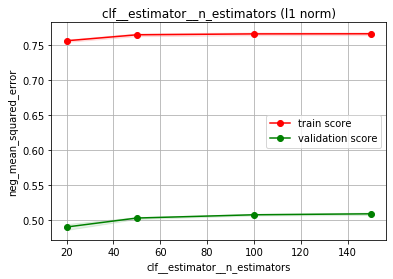

In [6]:
# validation curve to study the number of estimators

pipeline = Pipeline([
        ('vect',TfidfVectorizer(tokenizer=tokenize, norm='l1')),
        ('clf',MultiOutputClassifier(RandomForestClassifier(random_state=20)))
    ])

plot_validation_curve(pipeline,X_train, y_train, 'clf__estimator__n_estimators',[20, 50, 100, 150],3,'clf__estimator__n_estimators','clf__estimator__n_estimators (l1 norm)')



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Applications/anaconda3/lib/

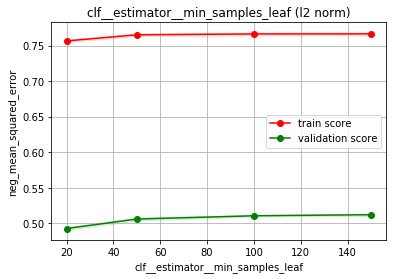

In [7]:
# validation curve to study the l1 norm or l2 norm

pipeline = Pipeline([
        ('vect',TfidfVectorizer(tokenizer=tokenize, norm='l2')),
        ('clf',MultiOutputClassifier(RandomForestClassifier(random_state=20)))
    ])

plot_validation_curve(pipeline,X_train, y_train, 'clf__estimator__n_estimators',[ 20, 50, 100, 150],3,'clf__estimator__min_samples_leaf','clf__estimator__min_samples_leaf (l2 norm)')



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Applications/anaconda3/lib/

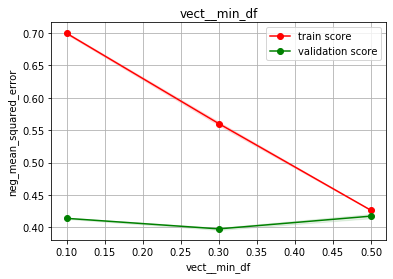

In [11]:
# validation curve to study the min_df

pipeline = Pipeline([
        ('vect',TfidfVectorizer(tokenizer=tokenize, norm='l2')),
        ('clf',MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=20)))
    ])

plot_validation_curve(pipeline,X_train, y_train, 'vect__min_df',[0.1, 0.3, 0.5], 3,'vect__min_df','vect__min_df')


In [13]:
model1 = Pipeline([
        ('vect',TfidfVectorizer(tokenizer=tokenize, norm='l2')),
        ('clf',MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=20)))
    ])
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
print(classification_report(y_test.values, y_pred, target_names=categories))

                        precision    recall  f1-score   support

               related       0.81      0.97      0.88      4010
               request       0.89      0.43      0.58       871
                 offer       0.00      0.00      0.00        27
           aid_related       0.80      0.60      0.69      2189
          medical_help       0.57      0.03      0.06       409
      medical_products       0.76      0.08      0.15       271
     search_and_rescue       0.67      0.06      0.10       144
              security       0.00      0.00      0.00        93
              military       0.75      0.02      0.03       175
           child_alone       0.00      0.00      0.00         0
                 water       0.85      0.25      0.39       310
                  food       0.86      0.45      0.59       557
               shelter       0.85      0.20      0.33       456
              clothing       0.86      0.08      0.14        79
                 money       1.00      

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.

In [34]:
def get_eval_metrics(actual, predicted, col_names):

    metrics = []
    
    # Calculate evaluation metrics for each set of labels
    for i in range(len(col_names)):
        accuracy = accuracy_score(actual[:, i], predicted[:, i])
        precision = precision_score(actual[:, i], predicted[:, i])
        recall = recall_score(actual[:, i], predicted[:, i])
        f1 = f1_score(actual[:, i], predicted[:, i])
        
        metrics.append([accuracy, precision, recall, f1])
    
    # Create dataframe containing metrics
    metrics = np.array(metrics)
    metrics_df = pd.DataFrame(data = metrics, index = col_names, columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
    
    mean_acc=metrics_df['Accuracy'].mean()
    mean_precision=metrics_df['Precision'].mean()
    mean_recall=metrics_df['Recall'].mean()
    mean_f1=metrics_df['F1'].mean()
    mean=pd.DataFrame([[mean_acc,mean_precision,mean_recall,mean_f1 ]], index = ['Avg Score'], columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
    
    metrics_df = pd.concat([metrics_df,mean])

    return metrics_df


In [35]:
get_eval_metrics(y_test.values, y_pred, col_names=categories)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


,Accuracy,Precision,Recall,F1
related,0.804120,0.808863,0.974065,0.883810
request,0.897196,0.891509,0.433984,0.583784
offer,0.994850,0.000000,0.000000,0.000000
aid_related,0.769598,0.796017,0.602558,0.685907
medical_help,0.922563,0.571429,0.029340,0.055814
medical_products,0.951173,0.758621,0.081181,0.146667
search_and_rescue,0.973298,0.666667,0.055556,0.102564
security,0.982262,0.000000,0.000000,0.000000
military,0.967004,0.750000,0.017143,0.033520
child_alone,1.000000,0.000000,0.000000,0.000000


### 6. Improve your model
Use grid search to find better parameters. 

In [37]:
def algo_PCA(X,pca):
    
    pca.fit(X.copy())
    
    # ------------------------------------------------------------
    """ explained_variance_ratio_"""
    # Percentage of variance explained by each of the selected components.
    fig,ax1 = plt.subplots()
    evr = ax1.bar([(i - 0.1) for i in range(len(pca.explained_variance_ratio_))],pca.explained_variance_ratio_,
                  width=0.2,color='k',align='center')
    ax1.set_xticks(np.arange(0,len(pca.explained_variance_ratio_),1))
    ax1.set_xlabel('Pricipal Components')
    ax1.set_ylabel('Explained Variance Ratio')

    """ singular_values_"""
    # corresponding to each of the selected components. equal to the 2-norms of the n_components variables in the lower-dimensional space.
    ax2 = ax1.twinx()
    sv = ax2.bar([(i + 0.1) for i in range(len(pca.singular_values_))],pca.singular_values_,width=0.2,color='b',
                 align='center')
    ax2.tick_params('y',colors='b')
    ax2.set_ylabel('Eigenvalues')

    plt.title('PCA Explained Variance and Eigenvalues')
    plt.legend([evr,sv],['Explained Variance Ratio','Eigenvalues'])
    plt.show()

    # --------------------------------------------------------------------------------
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_),'bx-')
    ax1.set_xticks(np.arange(0,len(pca.explained_variance_ratio_),1))  # Set label locations.
    for x,y in enumerate(np.cumsum(pca.explained_variance_ratio_)):
        label = "{:.2f}".format(y)
        plt.annotate(label,  # this is the text
                     (x,y),  # this is the point to label
                     textcoords="offset points",  # how to position the text
                     xytext=(0,-10),  # distance from text to points (x,y)
                     ha='center')  # horizontal alignment can be left, right or center
    plt.xlabel('Principal Components')
    plt.ylabel('cumulative explained variance');
    plt.title('PCA cumulative explained variance')
    plt.show()


In [38]:
X_token=TfidfVectorizer(X,tokenizer=tokenize)

## my PCA is not working, could mentor please advice how to apply PCA or other dimension reduction algorithms to this project? Help appreciated!

In [47]:
pca_pipeline=Pipeline([
        ('vect',TfidfVectorizer(tokenizer=tokenize, norm='l2')),
        ('scalar', StandardScaler()),
        ('pca',PCA(random_state=10) )
    ])
algo_PCA(X_train, pca_pipeline)

ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.